In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.neighbors import KDTree;
import os;
import re;
import logging;
import sqlite3;
import time;
import sys;
import multiprocessing;
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt;
from itertools import cycle;
import pickle
from operator import itemgetter
from fuzzywuzzy import process, fuzz
import spacy
import en_core_web_sm
%matplotlib inline
import networkx as nx

In [3]:
pf_df = pd.read_csv('kaggle_poem_dataset.csv')
pf_df['Author'] = pf_df.Author.astype('category')
pf_df.columns = [name.lower() for name in pf_df.columns]
pf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15652 entries, 0 to 15651
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   unnamed: 0            15652 non-null  int64   
 1   author                15652 non-null  category
 2   title                 15652 non-null  object  
 3   poetry foundation id  15652 non-null  int64   
 4   content               15652 non-null  object  
dtypes: category(1), int64(2), object(2)
memory usage: 674.7+ KB


<AxesSubplot:xlabel='author'>

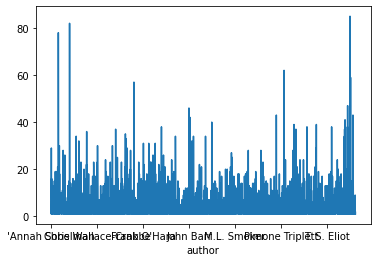

In [5]:
X = pf_df.copy()
fig, ax = plt.subplots()
X.groupby('author').count()['title'].plot(ax=ax)

        unnamed: 0        title  poetry foundation id      content
count  3310.000000  3310.000000           3310.000000  3310.000000
mean      4.728701     4.728701              4.728701     4.728701
std       6.428874     6.428874              6.428874     6.428874
min       1.000000     1.000000              1.000000     1.000000
25%       1.000000     1.000000              1.000000     1.000000
50%       2.000000     2.000000              2.000000     2.000000
75%       6.000000     6.000000              6.000000     6.000000
max      85.000000    85.000000             85.000000    85.000000


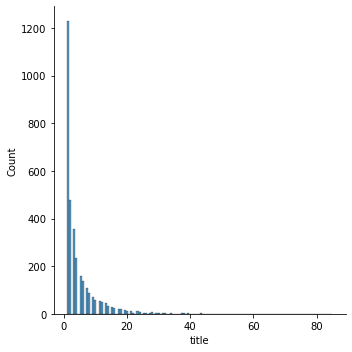

In [6]:
count_df = X.groupby('author').count()
print(count_df.describe())
sns.displot(data = count_df, x='title')

In [19]:
# convert corpus to python list
corpus = pf_df.content.tolist()

In [8]:
len(corpus)

15652

In [20]:
corpus[0] = '\n'.join([corpus[0], "\n I think that I shall never fear", 
                                   "a brontosaurus that is queer,",
                                   "\n iguanodon as fetisheer,",
                                   "a mammoth bringing up the rear,",
                                   "an astrodon with extra gear,",
                                   "\n metrosexual squirrel and deer,",
                                   "a breeder with a dance career,",
                                   "a fruit with cauliflower ear,",
                                   "\n a lesbianic Chanticleer,",
                                   "a grinning limpish-wristed Lear,",
                                   "the weird one or the mutineer,",
                                   "\n but those who perfectly adhere,",
                                   "stay clear, stay clear, stay clear, stay clear."])

In [21]:
print(corpus[0])

Dear Writers, I’m compiling the first in what I hope is a series of publications I’m calling artists among artists. The theme for issue 1 is “Faggot Dinosaur.” I hope to hear from you! Thank you and best wishes.

 I think that I shall never fear
a brontosaurus that is queer,

 iguanodon as fetisheer,
a mammoth bringing up the rear,
an astrodon with extra gear,

 metrosexual squirrel and deer,
a breeder with a dance career,
a fruit with cauliflower ear,

 a lesbianic Chanticleer,
a grinning limpish-wristed Lear,
the weird one or the mutineer,

 but those who perfectly adhere,
stay clear, stay clear, stay clear, stay clear.


In [22]:
with open('poetry_corpus.pkl', 'wb') as f:
    pickle.dump(corpus, f)

In [15]:
# load spacy's English model
nlp = en_core_web_sm.load()

In [19]:
import re
import html
import string
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV
from nltk.corpus import stopwords

def preprocess_text(text):
    cont_dict = { 
        "ain't": "am not / are not / is not / has not / have not",
        "aren't": "are not / am not",
        "can't": "cannot",
        "can't've": "cannot have",
        "'cause": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hadn't've": "had not have",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he had / he would",
        "he'd've": "he would have",
        "he'll": "he shall / he will",
        "he'll've": "he shall have / he will have",
        "he's": "he has / he is",
        "how'd": "how did",
        "how'd'y": "how do you",
        "how'll": "how will",
        "how's": "how has / how is / how does",
        "I'd": "I had / I would",
        "I'd've": "I would have",
        "I'll": "I shall / I will",
        "I'll've": "I shall have / I will have",
        "I'm": "I am",
        "I've": "I have",
        "isn't": "is not",
        "it'd": "it had / it would",
        "it'd've": "it would have",
        "it'll": "it shall / it will",
        "it'll've": "it shall have / it will have",
        "it's": "it has / it is",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "mightn't've": "might not have",
        "must've": "must have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "needn't": "need not",
        "needn't've": "need not have",
        "o'clock": "of the clock",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she had / she would",
        "she'd've": "she would have",
        "she'll": "she shall / she will",
        "she'll've": "she shall have / she will have",
        "she's": "she has / she is",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "so've": "so have",
        "so's": "so as / so is",
        "that'd": "that would / that had",
        "that'd've": "that would have",
        "that's": "that has / that is",
        "there'd": "there had / there would",
        "there'd've": "there would have",
        "there's": "there has / there is",
        "they'd": "they had / they would",
        "they'd've": "they would have",
        "they'll": "they shall / they will",
        "they'll've": "they shall have / they will have",
        "they're": "they are",
        "they've": "they have",
        "to've": "to have",
        "wasn't": "was not",
        "we'd": "we had / we would",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what shall / what will",
        "what'll've": "what shall have / what will have",
        "what're": "what are",
        "what's": "what has / what is",
        "what've": "what have",
        "when's": "when has / when is",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where has / where is",
        "where've": "where have",
        "who'll": "who shall / who will",
        "who'll've": "who shall have / who will have",
        "who's": "who has / who is",
        "who've": "who have",
        "why's": "why has / why is",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "won't've": "will not have",
        "would've": "would have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all'd've": "you all would have",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you had / you would",
        "you'd've": "you would have",
        "you'll": "you shall / you will",
        "you'll've": "you shall have / you will have",
        "you're": "you are",
        "you've": "you have"
        }

    stopwords_list = stopwords.words("english")
    try:
        while text.startswith('b'):
            text = text[1:]
        text = text.lower()
        for word in cont_dict.keys():
            pattern = re.compile(f'({str(word)})',re.I)
            text = pattern.sub(cont_dict[word],text)
    #     print(text[:50])
        tokens = word_tokenize(text)
        text = ' '.join([word for word in tokens if word not in stopwords_list])
    #     print(text[:50])
        text = ' '.join([''.join([c if c.isalnum() else ' ' for c in word]) for word in word_tokenize(text)])
        text = re.sub(' +', ' ', text)
        
    #     print(text[:50])
        return text.strip()
    
    except AttributeError:
        text = str(text)
        return preprocess_text(text)
    
    except TypeError:
        text = text.decode()[1:]
        return preprocess(text.strip())

def preprocess_corpus(corpus):
    return [preprocess_text(x) for x in corpus]

In [20]:
clean_corpus = preprocess_corpus(corpus)

In [21]:
entities = []

for poem in clean_corpus:
    tokens = nlp(''.join(poem))
    gpes = []
    for entity in tokens.ents:
        if entity.label_ == 'GPE':
            gpes.append(entity.text)
    entities.append(gpes)

print(entities)

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], ['corah', 'corah', 'corah'], [], [], [], [], [], [], [], [], [], [], [], [], [], [], ['ashland'], ['oregon'], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [

In [ ]:
choices = set([item for sublist in clean_corpus for item in sublist])

cleaned_articles = []
for poem in clean_corpus:
    poem_entities = []
    for entity in set(poem):
        article_entities.append(process.extractOne(entity, choices)[0])
    cleaned_articles.append(article_entities)